# Modules used in this project

In [5]:
# standard libraries
import os
import time
from datetime import datetime
import itertools
from itertools import chain, combinations
import warnings
warnings.filterwarnings('ignore')

# data analysis and manipulation
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning and model selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor

# statistical tools and analysis
from scipy.stats import pearsonr, shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# APIs and requests
import requests
import json

import time

import functions

# Functions used in this project

## Data visualization

In [160]:
def scatter_plots(df):
    columns = df.columns
    combinations = list(itertools.combinations(columns, 2))  
    for col1, col2 in combinations:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col1], y=df[col2])
        plt.title(f'Scatter Plot: {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(True)
        plt.show()

In [161]:
def plot_residuals(residuals_df):
    num_columns = len(residuals_df.columns)
    
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, 6 * num_columns), sharex=True)
    
    for i, column in enumerate(residuals_df.columns):
        axes[i].plot(residuals_df.index, residuals_df[column], label=f'Resíduo - {column}')
        axes[i].axhline(0, color='black', linewidth=1)
        axes[i].set_ylabel('Resíduos')
        axes[i].set_title(f'Resíduos - {column}')
        axes[i].legend()
    
    axes[-1].set_xlabel('Tempo')  
    plt.tight_layout()  
    plt.show()

In [162]:
def plot_autocorrelation(df, n_lags, autocorrelation_function):

    if autocorrelation_function == "ACF":
        for column in df.columns:
            plot_acf(df[column], lags = n_lags)
            plt.title(f"ACF for {column}")
            plt.tight_layout() 
            
    elif autocorrelation_function == "PACF":
        for column in df.columns:
                plot_pacf(df[column], lags = n_lags)
                plt.title(f"PACF for {column}")
                plt.tight_layout()
            
    else:
        print("Invalid autocorrelation function. Please try 'ACF' or 'PACF'")

## Statistics and data analysis

In [163]:
def correlation_with_lags(target_series, series_dict, max_lag):
    correlations = {}
    
    # Iterar sobre cada série no dicionário
    for series_name, other_series in series_dict.items():
        
        # Dicionário para armazenar as correlações de uma única série
        series_correlations = {}
        
        for lag in range(max_lag + 1):
            # Defasagem da outra série
            shifted_series = other_series.shift(lag)
            
            # Calcular correlação entre a série alvo e a série defasada
            correlation = target_series.corr(shifted_series)
            
            # Armazenar a correlação com o nome da coluna correspondente ao lag
            series_correlations[f'corr_lag_{lag}'] = correlation
        
        # Armazenar as correlações dessa série
        correlations[series_name] = series_correlations
    
    # Converter o dicionário em DataFrame
    result_df = pd.DataFrame(correlations).T 
    
    return result_df

In [164]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("A série não é estacionária (p > 0.05)")
    else:
        print("A série é estacionária (p <= 0.05)")

In [165]:
def shapiro_test(residuals_df):
    for column in residuals_df.columns:
        stat, p_value = shapiro(residuals_df[column])
        if p_value < 0.05:
            print(f"Variável: {column}, estatística: {stat}, p-value: {p_value}. Hipótese nula rejeitada. Os resíduos não são normalmente distribuídos")
        else: 
            print(f"Variável: {column}, estatística: {stat}, p-value: {p_value}. Hipótese nula não foi rejeitada. Os resíduos são normalmente distribuídos")

## Data preprocessing and manipulation

In [166]:
def split_train_test(X, y, train_size=0.8):
    split_index = int(len(X) * train_size)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    return X_train, X_test, y_train, y_test

In [167]:
def convert_unix_milliseconds_to_date(unix_milliseconds):
    # Convert milliseconds to seconds
    unix_seconds = unix_milliseconds / 1000
    # Create a datetime object from the Unix timestamp
    dt = datetime.fromtimestamp(unix_seconds)
    # Format the datetime object to a string in day/month/year format
    return dt.strftime('%d/%m/%Y')

In [168]:
def convert_to_date(df, date_column, freq='h'):
    df = df.assign(date=list(map(lambda x: convert_unix_milliseconds_to_date(x), 
                                        df[date_column])))
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    df['hour'] = pd.date_range(start='00:00', periods=len(df), freq=freq).time
    df['date_hour'] = df['date'] + pd.to_timedelta(df.groupby('date').cumcount(), unit=freq)
    df.index = df['date_hour']
    df = df.drop('date_hour', axis=1)
    return df

In [169]:
def get_all_combinations(columns):
    return list(chain.from_iterable(combinations(columns, r) for r in range(1, len(columns) + 1)))

In [170]:
def add_lags(df, num_lags):
    
    lagged_df = df.copy()

    for lag in range(1, num_lags + 1):
        lagged_columns = {
            f"{col}_lag_{lag}": df[col].shift(lag)
            for col in df.columns
        }
        lagged_df = pd.concat([lagged_df, pd.DataFrame(lagged_columns)], axis=1)

    lagged_df.dropna(inplace=True)

    return lagged_df

## Model training

In [171]:
def one_step_ahead_forecasting(X, y, model, starting_point):
    '''predict the next observation of a time series using as training set all the past observations'''
    
    predictions = np.array([])
    print('Treinando')
    X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point = starting_point)
    print('Fit')
    model.fit(X_train.values, y_train.values)
    print('Fit final')
    for i in range(len(X_test)):
        predictions = np.append(predictions, (model.predict(X_test.iloc[i].values.reshape(1, -1))))
        print('Predição')
        X_train = pd.concat([X_train, X_test.iloc[i].to_frame().T])
        y_train = np.append(y_train, y_test.iloc[i].reshape(1, -1))
        
        y_train = pd.Series(y_train)
        
        model.fit(X_train.values, y_train.values)
        
    return predictions

In [172]:
def one_step_ahead_forecasting_AR(y, starting_point_percent, lags):
    '''Faz previsão one-step-ahead utilizando modelo autoregressivo (AR) e um ponto de início baseado em porcentagem'''
    
    predictions = np.array([])
    print(f'Treinando modelo AR com {lags} lags')

    # Definindo o ponto de início como porcentagem dos dados
    starting_point = int(len(y) * starting_point_percent)
    
    # Dividindo o conjunto de treino e teste a partir do ponto de início
    y_train = y[:starting_point]
    y_test = y[starting_point:]

    # Criando o modelo autoregressivo inicial
    model = AutoReg(y_train, lags=lags)
    model_fit = model.fit()

    # Previsão one-step-ahead
    for i in range(len(y_test)):
        # Prevendo o próximo valor (one-step-ahead)
        pred = model_fit.predict(start=len(y_train), end=len(y_train), dynamic=False)
        predictions = np.append(predictions, pred)
        
        # Adiciona o valor real ao conjunto de treino
        y_train = np.append(y_train, y_test.iloc[i])
        
        # Ajusta o modelo novamente com o novo valor adicionado
        model = AutoReg(y_train, lags=lags)
        model_fit = model.fit()
    
    return predictions

In [173]:
def fit_ar_model(df, starting_point_percent, lags_list):
    '''Treina o modelo AR com uma lista de lags e retorna DataFrames de performance e resíduos'''
    
    performance_dict = {}
    residuals_dict = {}

    for lags in lags_list:
        print(f'Treinando para {lags} lags')
        
        for column in df.columns:
            print(f'Treinando com a variável: {column}')
            
            # Previsão com AR
            predictions = one_step_ahead_forecasting_AR(y=df[column], starting_point_percent=starting_point_percent, lags=lags)
            
            # Avaliando a performance
            actual = df[column].iloc[int(len(df[column]) * starting_point_percent):]
            mse, mae = evaluate_performance(predictions=predictions, actual=actual)
            performance_dict[(column, lags)] = [mse, mae]

            # Calculando os resíduos
            residuals = predictions - actual.values
            residuals_dict[(column, lags)] = residuals

            # Modelo Naive: previsão t = valor de t-1 para a variável
            predictions_naive = df[column].shift(1).iloc[int(len(df[column]) * starting_point_percent):]
            predictions_naive = predictions_naive.dropna()
            mse_naive, mae_naive = evaluate_performance(predictions=predictions_naive, actual=actual)
            performance_dict[('Naive_' + column, lags)] = [mse_naive, mae_naive]
    
    # Convertendo os dicionários de performance e resíduos para DataFrames
    performance_df = pd.DataFrame.from_dict(performance_dict, orient='index', columns=['MSE', 'MAE'])
    performance_df.index = pd.MultiIndex.from_tuples(performance_df.index, names=["Variable", "Lags"])
    
    # Resíduos: Cada variável terá seus resíduos para cada lag
    residuals_df = pd.DataFrame(residuals_dict)
    residuals_df.columns = pd.MultiIndex.from_tuples(residuals_df.columns, names=["Variable", "Lags"])
    residuals_df.index = df[column].iloc[int(len(df[column]) * starting_point_percent):].index[:len(residuals_df)]

    return performance_df, residuals_df

In [174]:
def one_step_ahead_forecasting_AR_exog(y, X, starting_point_percent, lags):
    """Faz previsão one-step-ahead utilizando modelo autoregressivo (AR) com variáveis exógenas e lags."""
    predictions = []
    print('Treinando modelo AR com variáveis exógenas e lags')
    
    # Definir o ponto de início
    starting_point = int(len(y) * starting_point_percent)
    
    # Dividindo o conjunto de treino e teste
    y_train = y[:starting_point].values  # Convertendo para numpy array
    y_test = y[starting_point:].values  # Convertendo para numpy array
    
    X_train = X.iloc[:starting_point].values  # Garantindo formato correto
    X_test = X.iloc[starting_point:].values  # Garantindo formato correto
    
    # Criar e ajustar o modelo inicial
    model = AutoReg(y_train, lags=lags, exog=X_train)
    model_fit = model.fit()
    print('Modelo ajustado')
    
    for i in range(len(y_test)):
        print(f'Predição passo {i+1}')
        
        if i >= len(X_test):  # Evita erro de indexação
            break
        
        exog_oos = X_test[i].reshape(1, -1)  # Garantir que exog seja 2D
        pred = model_fit.predict(start=len(y_train), end=len(y_train), exog_oos=exog_oos, dynamic=False)
        
        if pred.size > 0:
            predictions.append(pred[0])
        else:
            predictions.append(np.nan)  # Evita erro caso a previsão falhe
        
        # Atualizar conjunto de treino
        y_train = np.append(y_train, y_test[i])
        X_train = np.vstack([X_train, X_test[i]])
        
        # Ajustar modelo novamente
        model = AutoReg(y_train, lags=lags, exog=X_train)
        model_fit = model.fit()
    
    return np.array(predictions)

In [175]:
def fit_ar_model_exog(df, target_column, starting_point_percent, lags_list):
    """Treina o modelo AR com variáveis exógenas para diferentes lags e retorna DataFrames de performance e resíduos."""
    performance_dict = {}
    residuals_dict = {}
    
    y = df[target_column]
    X = df.drop(target_column, axis=1)
    
    # Gerar todas as combinações possíveis das variáveis exógenas
    exog_combinations = get_all_combinations(X.columns)
    
    for lags in lags_list:
        print(f'Treinando para {lags} lags')
        
        for combo in exog_combinations:
            print(f'Treinando com variáveis exógenas: {combo}')
            
            X_subset = X[list(combo)]  # Seleciona as colunas da combinação
            
            predictions = one_step_ahead_forecasting_AR_exog(y=y, X=X_subset, starting_point_percent=starting_point_percent, lags=lags)
            
            actual = y.iloc[int(len(y) * starting_point_percent):].values
            actual = actual[:len(predictions)]  # Garantir tamanhos compatíveis
            
            if len(predictions) != len(actual):
                print(f"Inconsistência de tamanho! Predictions: {len(predictions)}, Actual: {len(actual)}")
                continue
            
            mse, mae = evaluate_performance(predictions=predictions, actual=actual)
            performance_dict[(combo, lags)] = [mse, mae]
            
            residuals = predictions - actual
            residuals_dict[(combo, lags)] = residuals
            
            # Modelo Naive
            predictions_naive = y.shift(1).iloc[int(len(y) * starting_point_percent):].dropna().values
            predictions_naive = predictions_naive[:len(actual)]
            
            if len(predictions_naive) != len(actual):
                continue
            
            mse_naive, mae_naive = evaluate_performance(predictions=predictions_naive, actual=actual)
            performance_dict[('Naive_' + '_'.join(combo), lags)] = [mse_naive, mae_naive]
    
    # Convertendo os dicionários de performance e resíduos para DataFrames
    performance_df = pd.DataFrame.from_dict(performance_dict, orient='index', columns=['MSE', 'MAE'])
    performance_df.index = pd.MultiIndex.from_tuples(performance_df.index, names=["Variables", "Lags"])
    
    residuals_df = pd.DataFrame(residuals_dict)
    residuals_df.columns = pd.MultiIndex.from_tuples(residuals_df.columns, names=["Variables", "Lags"])
    residuals_df.index = y.iloc[int(len(y) * starting_point_percent):].index[:len(residuals_df)]
    
    return performance_df, residuals_df

## Model validation

In [176]:
def time_series_cross_validation(X_train, y_train, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    errors = []

    # Iniciar o contador de tempo
    start_time = time.time()

    for train_index, val_index in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_t, y_t)
        predictions = model.predict(X_val)

        mse = mean_squared_error(y_val, predictions)
        errors.append(mse)

    # Finalizar o contador de tempo
    end_time = time.time()
    total_time = end_time - start_time

    # Exibir o tempo total de treinamento
    print(f"Total training time: {total_time:.2f} seconds")

    return np.mean(errors)

In [177]:
def hyperparameter_optimization(X_train, y_train, model, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        print(f"Testando a combinação {params}")
        model.set_params(**params)
        mse = time_series_cross_validation(X_train, y_train, model, n_splits=5)

        result = params.copy()
        result["mse"] = mse
        results.append(result)
    return pd.DataFrame(results)

In [178]:
def final_model_evaluation(X_train, y_train, X_test, y_test, model, best_params):
    """
    Trains the model on the training data and evaluates on the test set.
    Filters out invalid hyperparameters before setting them.
    """
    # Get valid hyperparameters for the model
    valid_params = model.get_params().keys()
    
    # Filter only valid hyperparameters
    filtered_params = {k: v for k, v in best_params.items() if k in valid_params}

    # Set the valid hyperparameters
    model.set_params(**filtered_params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Calculate MSE
    final_mse = mean_squared_error(y_test, predictions)
    
    return final_mse, predictions

In [179]:
def optimize_and_evaluate(X, y, models_and_params, train_size=0.8):
    X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.8)
    all_results = pd.DataFrame()

    for model_name, model_info in models_and_params.items():
        print(f"Otimizando {model_name}...")
        
        # Medir o tempo de início do treinamento
        start_time = time.time()

        # Otimização dos hiperparâmetros
        results_df = hyperparameter_optimization(
            X_train, y_train, model_info["model"], model_info["params"]
        )
        
        # Tempo de treinamento
        training_time = time.time() - start_time
        print(f"Tempo de treinamento para {model_name}: {training_time:.2f} segundos")
        
        results_df["model"] = model_name
        results_df["training_time"] = training_time  # Adicionando a coluna de tempo de treinamento

        best_params = results_df.sort_values(by="mse").iloc[0].drop("mse").to_dict()
        
        # Avaliação final com os melhores parâmetros
        final_mse, predictions = final_model_evaluation(
            X_train, y_train, X_test, y_test, model_info["model"], best_params
        )

        print(f"{model_name} - MSE Final no Teste: {final_mse:.4f}")
        results_df["final_test_mse"] = final_mse
        all_results = pd.concat([all_results, results_df], ignore_index=True)

    return all_results

In [180]:
def optimize_and_evaluate_one_lag(df, models_and_params):
    all_results = pd.DataFrame()

    for column in df.columns:
        print(f"\n🔍 Processing column: {column}")

        # Create lagged feature (lag 1)
        lagged_df = pd.DataFrame({
            f"{column}_lag_1": df[column].shift(1),
            column: df[column]
        }).dropna()

        # Define X and y
        X = lagged_df[[f"{column}_lag_1"]]
        y = lagged_df[column]

        # Split into train and test sets
        X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.8)

        # Apply models to each column
        for model_name, model_info in models_and_params.items():
            print(f"⚙️ Optimizing model: {model_name} for {column}")

            # Hyperparameter optimization
            results_df = hyperparameter_optimization(
                X_train, y_train, model_info["model"], model_info["params"]
            )
            results_df["model"] = model_name
            results_df["series"] = column

            # Best hyperparameters
            best_params = results_df.sort_values(by="mse").iloc[0].drop("mse").to_dict()

            # Final evaluation
            final_mse, predictions = final_model_evaluation(
                X_train, y_train, X_test, y_test, model_info["model"], best_params
            )

            print(f"✅ {model_name} for {column} - Final MSE on Test: {final_mse:.4f}")

            # Store results
            results_df["final_test_mse"] = final_mse
            all_results = pd.concat([all_results, results_df], ignore_index=True)

    return all_results

In [181]:
def evaluate_all_feature_combinations(df, target, exogenous_vars, model, param_grid):
    results = pd.DataFrame()

    # Generate all possible combinations of exogenous variables + lagged target
    all_features = [f"{target}_lag_1"] + exogenous_vars
    feature_combinations = []
    for i in range(1, len(all_features) + 1):
        feature_combinations.extend(combinations(all_features, i))

    # Loop through all feature combinations
    for feature_set in feature_combinations:
        print(f"\n🔍 Evaluating feature set: {feature_set}")
        X = df[list(feature_set)]
        y = df[target]
        
        # Drop rows with NaNs caused by lags
        data = pd.concat([X, y], axis=1).dropna()
        X = data[list(feature_set)]
        y = data[target]

        # Train-test split
        X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.8)

        # Optimize hyperparameters for the current feature set
        results_df = hyperparameter_optimization(X_train, y_train, model, param_grid)
        results_df["features"] = [feature_set] * len(results_df)

        # Get best hyperparameters based on MSE
        best_params = results_df.sort_values(by="mse").iloc[0].drop("mse").to_dict()
        final_mse, predictions = final_model_evaluation(
            X_train, y_train, X_test, y_test, model, best_params
        )

        print(f"✅ Features: {feature_set} - Final MSE on Test: {final_mse:.4f}")
        results_df["final_test_mse"] = final_mse

        # Store the results
        results = pd.concat([results, results_df], ignore_index=True)

    return results

In [182]:
def final_model_evaluation(X_train, y_train, X_test, y_test, model, best_params):
    valid_params = model.get_params().keys()
    
    # Filter valid hyperparameters
    filtered_params = {k: v for k, v in best_params.items() if k in valid_params}

    # Convert floats to integers if necessary
    integer_params = [
        'max_depth', 'max_leaf_nodes', 'min_samples_split', 'min_samples_leaf', 'n_estimators'
    ]
    for param in integer_params:
        if param in filtered_params and isinstance(filtered_params[param], float):
            filtered_params[param] = int(filtered_params[param])

    # Train the model
    model.set_params(**filtered_params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    final_mse = mean_squared_error(y_test, predictions)

    return final_mse, predictions

## Model evaluation

In [183]:
def evaluate_performance(predictions, actual):
    '''Evaluates model's performance using MSE, MAE e R²'''
    
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    
    return [mse, mae]

# Getting the data

In [70]:
criptos = pd.read_csv(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\input_data\criptos_final.csv", 
                      delimiter = ",")

In [71]:
criptos_diff = pd.read_csv(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\input_data\criptos_diff_final.csv", 
                      delimiter = ",")

## Plots

### Base 100

In [72]:
criptos_base_100 = criptos[features] / criptos[features].iloc[0] * 100

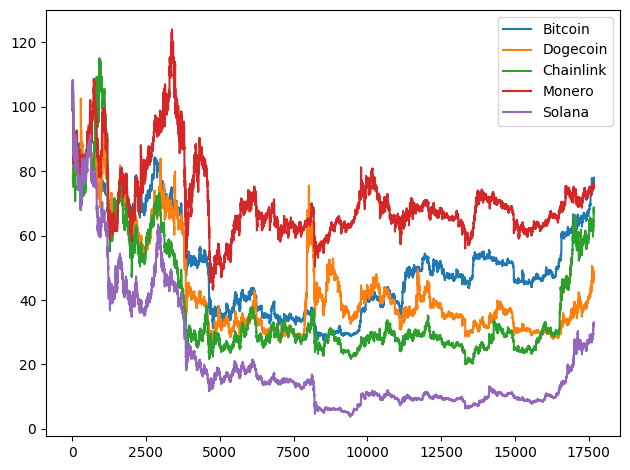

In [73]:
criptos_base_100[features].plot()

plt.tight_layout()

In [74]:
criptos_base_100.to_excel('plots/criptos_base_100.xlsx')

### Standard

In [75]:
criptos_standard = (criptos[features] - criptos[features].mean()) / criptos[features].std()

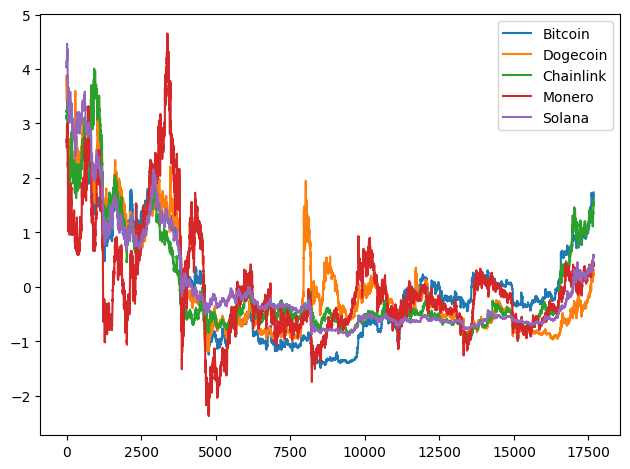

In [76]:
criptos_standard[features].plot()

plt.tight_layout()

In [77]:
criptos_standard.to_excel('plots/criptos_standard.xlsx')

### Standard with Difference

In [78]:
criptos_standard_diff = criptos_standard[features] - criptos_standard[features].shift(1)
criptos_standard_diff = criptos_standard_diff.dropna()

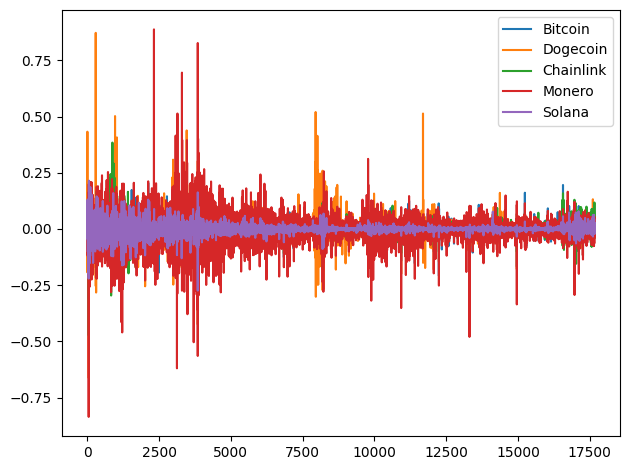

In [79]:
criptos_standard_diff[features].plot()

plt.tight_layout()

In [80]:
criptos_standard_diff.to_excel('plots/criptos_standard_diff.xlsx')

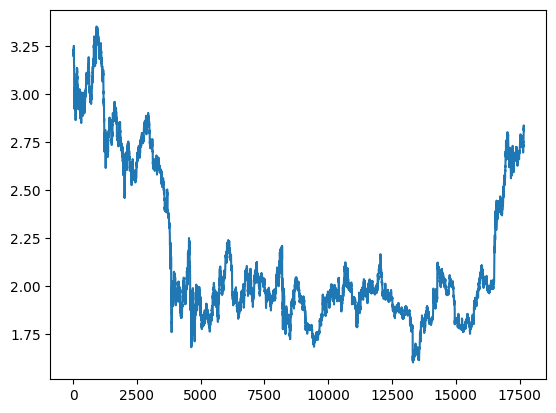

In [81]:
plt.plot(np.log(criptos.Chainlink))

## Correlations

### Scatter plots

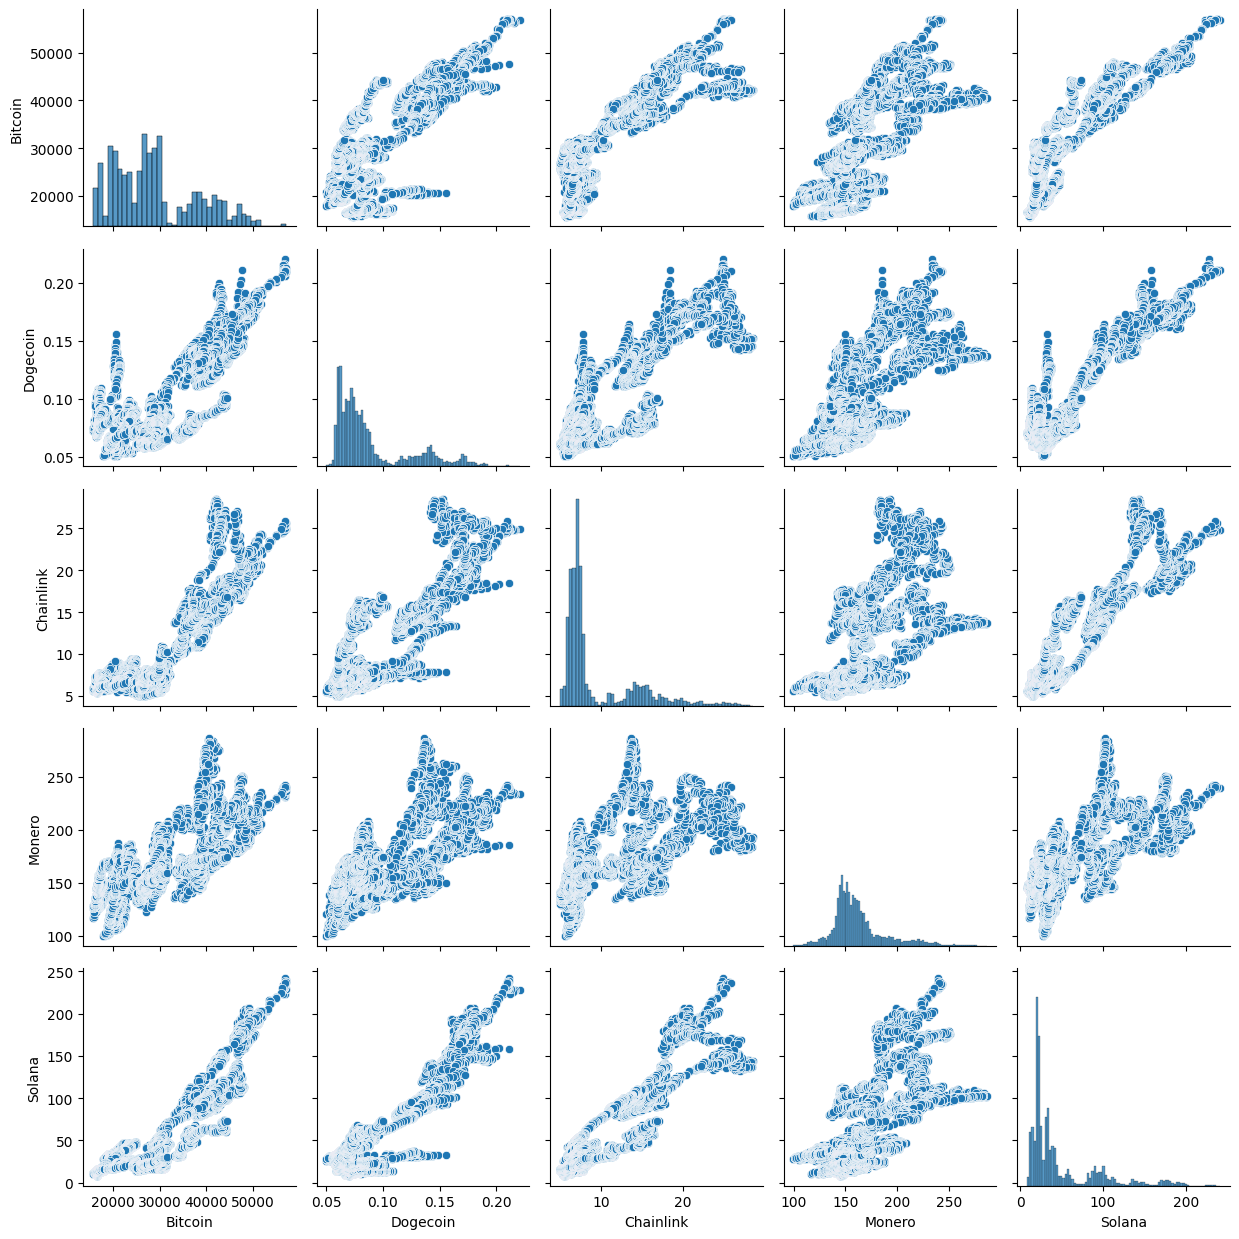

In [82]:
sns.pairplot(criptos)

plt.tight_layout()

In [83]:
criptos.corr()

ValueError: could not convert string to float: '2021-12-02 00:00:00'

In [ ]:
criptos_diff = (criptos - criptos.shift(1)) / criptos.shift(1)

In [ ]:
criptos_diff = criptos_diff.dropna()

In [ ]:
criptos_diff

In [ ]:
sns.pairplot(criptos_diff)

plt.tight_layout()

In [ ]:
criptos_diff.corr()

## Correlations with lags

In [ ]:
series_dict = {
    'Bitcoin': criptos['Bitcoin'],
    'DogeCoin': criptos['Dogecoin'],
    'Chainlink': criptos['Chainlink'],
    'Monero': criptos['Monero'],
    'Solana': criptos['Solana']
}

In [ ]:
series_dict_diff = {
    'Bitcoin': criptos_diff['Bitcoin'],
    'DogeCoin': criptos_diff['Dogecoin'],
    'Chainlink': criptos_diff['Chainlink'],
    'Monero': criptos_diff['Monero'],
    'Solana': criptos_diff['Solana']
}

### Bitcoin

In [ ]:
functions.correlation_with_lags(criptos['Bitcoin'], series_dict, max_lag = 200)

In [ ]:
functions.correlation_with_lags(criptos_diff['Bitcoin'], series_dict_diff, max_lag = 200)

### Dogecoin

In [ ]:
functions.correlation_with_lags(criptos['Dogecoin'], series_dict, max_lag = 10)

In [ ]:
functions.correlation_with_lags(criptos_diff['Dogecoin'], series_dict_diff, max_lag = 10)

### ChainLink

In [ ]:
functions.correlation_with_lags(criptos['Chainlink'], series_dict, max_lag = 10)

In [ ]:
functions.correlation_with_lags(criptos_diff['Chainlink'], series_dict_diff, max_lag = 10)

### Monero

In [ ]:
functions.correlation_with_lags(criptos['Monero'], series_dict, max_lag = 10)

In [ ]:
functions.correlation_with_lags(criptos_diff['Monero'], series_dict_diff, max_lag = 10)

### Solana

In [ ]:
functions.correlation_with_lags(criptos['Solana'], series_dict, max_lag = 10)

In [ ]:
functions.correlation_with_lags(criptos_diff['Solana'], series_dict_diff, max_lag = 10)

## AR model

### Stationarity

#### Original series

In [ ]:
functions.check_stationarity(criptos['Bitcoin'])

#### Diff series

In [ ]:
functions.check_stationarity(criptos_diff['Bitcoin'])

## AR Models

First, we are going to apply the AR model to every time series with itself

## Autocorrelation

In [ ]:
N_LAGS = 20

### ACF

In [ ]:
functions.plot_autocorrelation(df = criptos_diff, n_lags = N_LAGS, autocorrelation_function = 'ACF')

### PACF

In [ ]:
functions.plot_autocorrelation(df = criptos_diff, n_lags = N_LAGS, autocorrelation_function = 'PACF')

## Creating the models

In [225]:
LAGS = [1]
STARTING_POINT = 0.8

In [68]:
performance, residuals = fit_ar_model(criptos_diff, starting_point_percent = STARTING_POINT, lags_list = LAGS)

NameError: name 'fit_ar_model' is not defined

In [227]:
performance.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_performance_table.xlsx")

In [228]:
performance

MSE       MAE
Variable        Lags                    
Bitcoin         1     0.000015  0.002280
Naive_Bitcoin   1     0.000033  0.003503
Dogecoin        1     0.000046  0.004165
Naive_Dogecoin  1     0.000096  0.006202
Chainlink       1     0.000071  0.005637
Naive_Chainlink 1     0.000145  0.008377
Monero          1     0.000019  0.003054
Naive_Monero    1     0.000041  0.004565
Solana          1     0.000089  0.006219
Naive_Solana    1     0.000181  0.009236

In [272]:
residuals.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\residuals\residuals_ar_simple.xlsx")

## Adding exogenous variables

In [230]:
performance_exog, residuals_exog = fit_ar_model_exog(df = criptos_diff, target_column = 'Bitcoin', starting_point_percent = STARTING_POINT, lags_list = LAGS)

Treinando para 1 lags
Treinando com variáveis exógenas: ('Dogecoin',)
Treinando modelo AR com variáveis exógenas e lags
Modelo ajustado
Predição passo 1
Predição passo 2
Predição passo 3
Predição passo 4
Predição passo 5
Predição passo 6
Predição passo 7
Predição passo 8
Predição passo 9
Predição passo 10
Predição passo 11
Predição passo 12
Predição passo 13
Predição passo 14
Predição passo 15
Predição passo 16
Predição passo 17
Predição passo 18
Predição passo 19
Predição passo 20
Predição passo 21
Predição passo 22
Predição passo 23
Predição passo 24
Predição passo 25
Predição passo 26
Predição passo 27
Predição passo 28
Predição passo 29
Predição passo 30
Predição passo 31
Predição passo 32
Predição passo 33
Predição passo 34
Predição passo 35
Predição passo 36
Predição passo 37
Predição passo 38
Predição passo 39
Predição passo 40
Predição passo 41
Predição passo 42
Predição passo 43
Predição passo 44
Predição passo 45
Predição passo 46
Predição passo 47
Predição passo 48
Predição 

In [231]:
performance_exog.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_exog_performance_table.xlsx")

In [232]:
performance_exog

MSE       MAE
Variables                              Lags                    
(Dogecoin,)                            1     0.000011  0.001951
Naive_Dogecoin                         1     0.000033  0.003503
(Chainlink,)                           1     0.000013  0.002326
Naive_Chainlink                        1     0.000033  0.003503
(Monero,)                              1     0.000011  0.002126
Naive_Monero                           1     0.000033  0.003503
(Solana,)                              1     0.000010  0.001995
Naive_Solana                           1     0.000033  0.003503
(Dogecoin, Chainlink)                  1     0.000010  0.002133
Naive_Dogecoin_Chainlink               1     0.000033  0.003503
(Dogecoin, Monero)                     1     0.000009  0.001914
Naive_Dogecoin_Monero                  1     0.000033  0.003503
(Dogecoin, Solana)                     1     0.000009  0.001851
Naive_Dogecoin_Solana                  1     0.000033  0.003503
(Chainlink, Monero)                    1     0.000010  0.002113
Naive_Chainlink_Monero                 1     0.000033  0.003503
(Chainlink, Solana)                    1     0.000010  0.002083
Naive_Chainlink_Solana                 1     0.000033  0.003503
(Monero, Solana)                       1     0.000009  0.001892
Naive_Monero_Solana                    1     0.000033  0.003503
(Dogecoin, Chainlink, Monero)          1     0.000009  0.001984
Naive_Dogecoin_Chainlink_Monero        1     0.000033  0.003503
(Dogecoin, Chainlink, Solana)          1     0.000009  0.001972
Naive_Dogecoin_Chainlink_Solana        1     0.000033  0.003503
(Dogecoin, Monero, Solana)             1     0.000008  0.001794
Naive_Dogecoin_Monero_Solana           1     0.000033  0.003503
(Chainlink, Monero, Solana)            1     0.000009  0.001940
Naive_Chainlink_Monero_Solana          1     0.000033  0.003503
(Dogecoin, Chainlink, Monero, Solana)  1     0.000008  0.001862
Naive_Dogecoin_Chainlink_Monero_Solana 1     0.000033  0.003503

## Using logs

In [233]:
criptos_log = np.log(criptos)

In [234]:
criptos_log_diff = criptos_log - criptos_log.shift(1)
criptos_log_diff = criptos_log_diff.dropna()

In [235]:
criptos_diff

Bitcoin  Dogecoin  Chainlink    Monero    Solana
date_hour                                                             
2021-12-02 01:00:00 -0.004322  0.000049  -0.001331  0.005241  0.000672
2021-12-02 02:00:00  0.002953  0.001546   0.002948 -0.002241 -0.001053
2021-12-02 03:00:00  0.002260  0.070560   0.000523  0.009761  0.022487
2021-12-02 04:00:00 -0.004648 -0.029450  -0.000885 -0.000214 -0.002829
2021-12-02 05:00:00 -0.002085  0.010804  -0.000201  0.001583  0.001724
...                       ...       ...        ...       ...       ...
2023-12-08 12:00:00  0.001407  0.004597  -0.004732  0.001157  0.012649
2023-12-08 13:00:00 -0.001971  0.000305   0.005176  0.000578  0.010844
2023-12-08 14:00:00  0.001614  0.002236  -0.005808 -0.001155 -0.011814
2023-12-08 15:00:00  0.003243  0.016939   0.010539 -0.000578 -0.006596
2023-12-08 16:00:00  0.009368  0.003491   0.003397  0.008097  0.015355

[17673 rows x 5 columns]

In [236]:
criptos_log_diff

Bitcoin  Dogecoin  Chainlink    Monero    Solana
date_hour                                                             
2021-12-02 01:00:00 -0.004331  0.000049  -0.001332  0.005228  0.000672
2021-12-02 02:00:00  0.002949  0.001545   0.002944 -0.002243 -0.001053
2021-12-02 03:00:00  0.002257  0.068182   0.000523  0.009713  0.022238
2021-12-02 04:00:00 -0.004659 -0.029893  -0.000886 -0.000214 -0.002833
2021-12-02 05:00:00 -0.002087  0.010746  -0.000201  0.001582  0.001723
...                       ...       ...        ...       ...       ...
2023-12-08 12:00:00  0.001406  0.004586  -0.004743  0.001156  0.012570
2023-12-08 13:00:00 -0.001973  0.000305   0.005162  0.000578  0.010786
2023-12-08 14:00:00  0.001613  0.002234  -0.005825 -0.001155 -0.011885
2023-12-08 15:00:00  0.003238  0.016797   0.010484 -0.000578 -0.006618
2023-12-08 16:00:00  0.009325  0.003485   0.003391  0.008065  0.015238

[17673 rows x 5 columns]

### Simple AR(1) models

In [237]:
# performance_log, residuals_log = fit_ar_model(criptos_log_diff, starting_point_percent = STARTING_POINT, lags_list = LAGS)

In [238]:
# performance_log.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_log_performance_table.xlsx")

### Exogenous

In [239]:
# performance_exog_log, residuals_exog_log = fit_ar_model_exog(df = criptos_log_diff, target_column = 'Bitcoin', starting_point_percent = STARTING_POINT, lags_list = LAGS)

In [240]:
# performance_exog_log.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_exog_log_performance_table.xlsx")

In [241]:
# performance_exog_log

## Residual analysis

In [273]:
residuals = residuals.iloc[:,:5]

In [243]:
# residuals_exog =  residuals_exog.iloc[:, :4]

In [244]:
# residuals_exog_log = residuals_exog_log.iloc[:, :4]

### Scatter plot

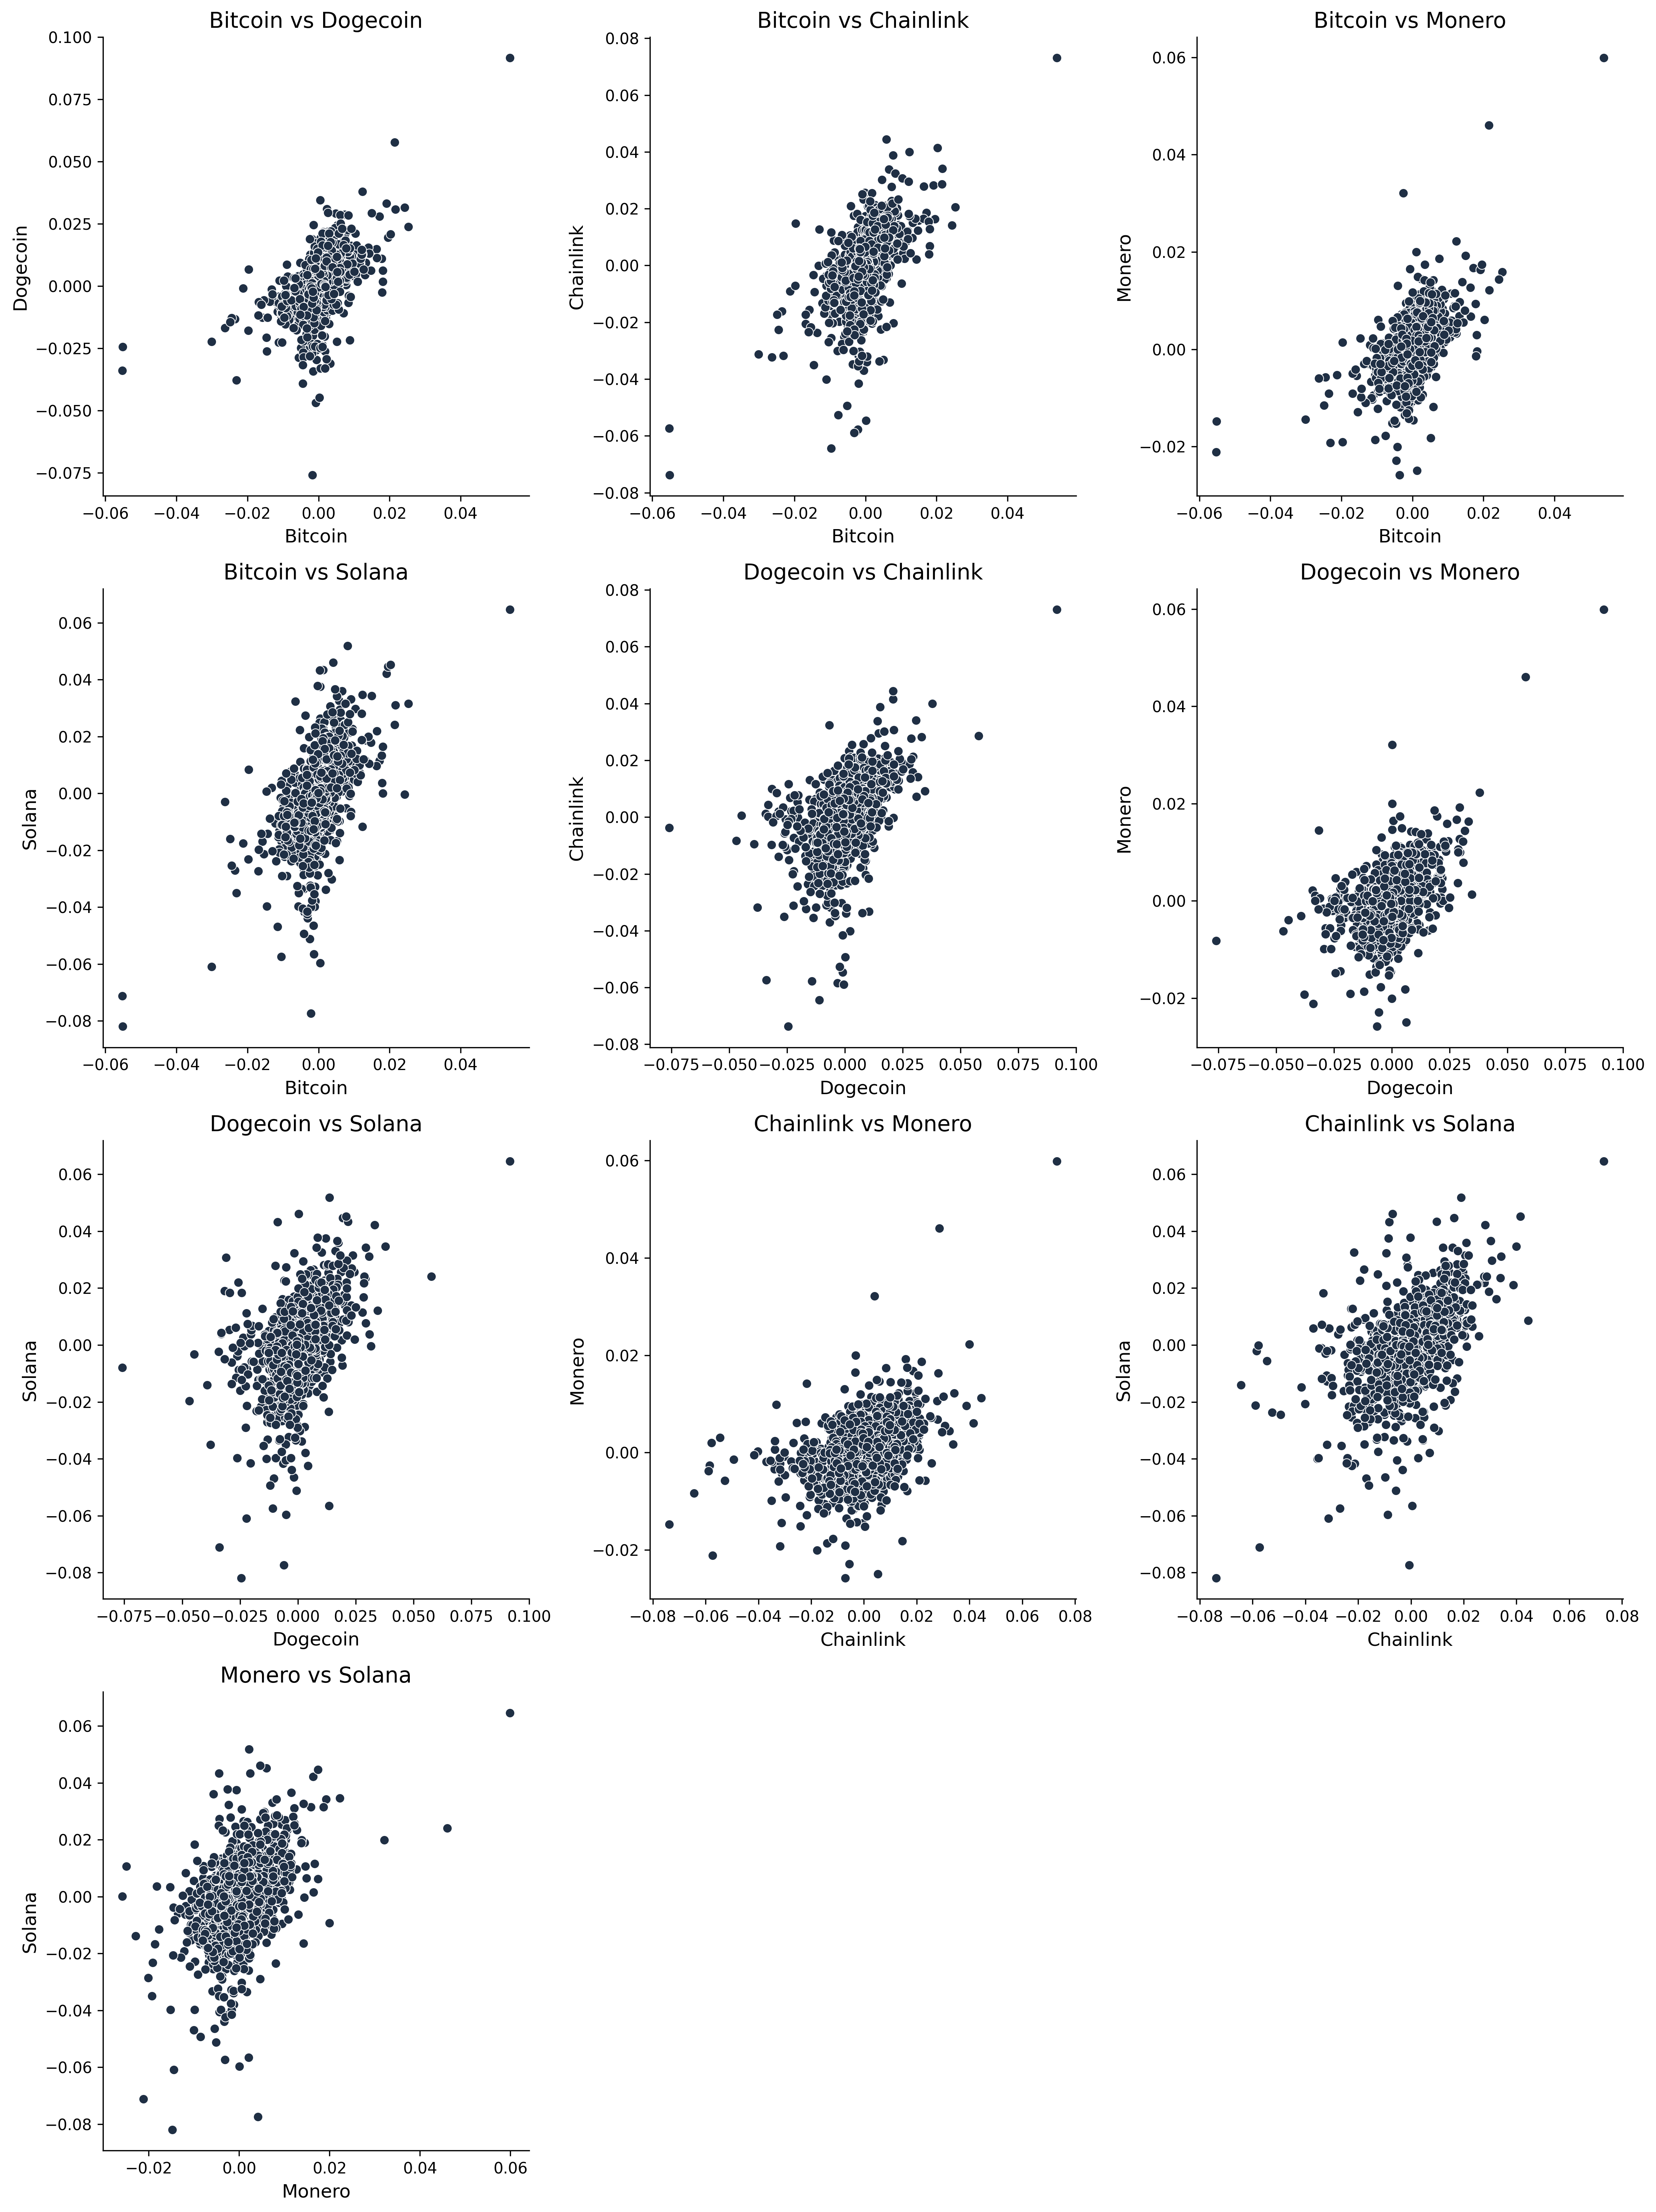

In [278]:
# Converter RGB para formato normalizado (0-1)
rgb_color = np.array([31, 47, 68]) / 255  # Normalizando valores RGB

# Criar pasta para salvar as imagens
output_folder = r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data"
os.makedirs(output_folder, exist_ok=True)

# Definir número de colunas para os subplots
num_cols = 3  # Número fixo de colunas
num_pairs = len(criptos.columns) * (len(criptos.columns) - 1) // 2  # Número total de combinações
num_rows = (num_pairs // num_cols) + (num_pairs % num_cols > 0)  # Ajuste para múltiplas linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=300)  # DPI alto para melhor qualidade
axes = axes.flatten()  # Transforma a matriz de eixos em um array 1D

# Gerar os gráficos de dispersão para todas as combinações de pares
pair_idx = 0  # Índice para percorrer os pares
for i in range(len(criptos.columns)):
    for j in range(i + 1, len(criptos.columns)):
        sns.scatterplot(data=residuals, x=residuals.columns[i], y=residuals.columns[j], ax=axes[pair_idx], color=rgb_color)
        axes[pair_idx].set_title(f'{criptos.columns[i]} vs {criptos.columns[j]}', fontsize=14)
        axes[pair_idx].set_xlabel(criptos.columns[i], fontsize=12)  # Aumentando a fonte do rótulo do eixo X
        axes[pair_idx].set_ylabel(criptos.columns[j], fontsize=12)  # Aumentando a fonte do rótulo do eixo Y

        # Remover bordas superiores e direitas
        axes[pair_idx].spines['top'].set_visible(False)
        axes[pair_idx].spines['right'].set_visible(False)

        pair_idx += 1

# Remover subplots vazios, caso o número de gráficos não seja múltiplo de 3
for j in range(pair_idx, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout e salvar a imagem com qualidade alta
plt.tight_layout()
fig.savefig(os.path.join(output_folder, "residuals_scatter_ar.png"), dpi=300, bbox_inches="tight")  # Salvar com DPI alto
plt.show()

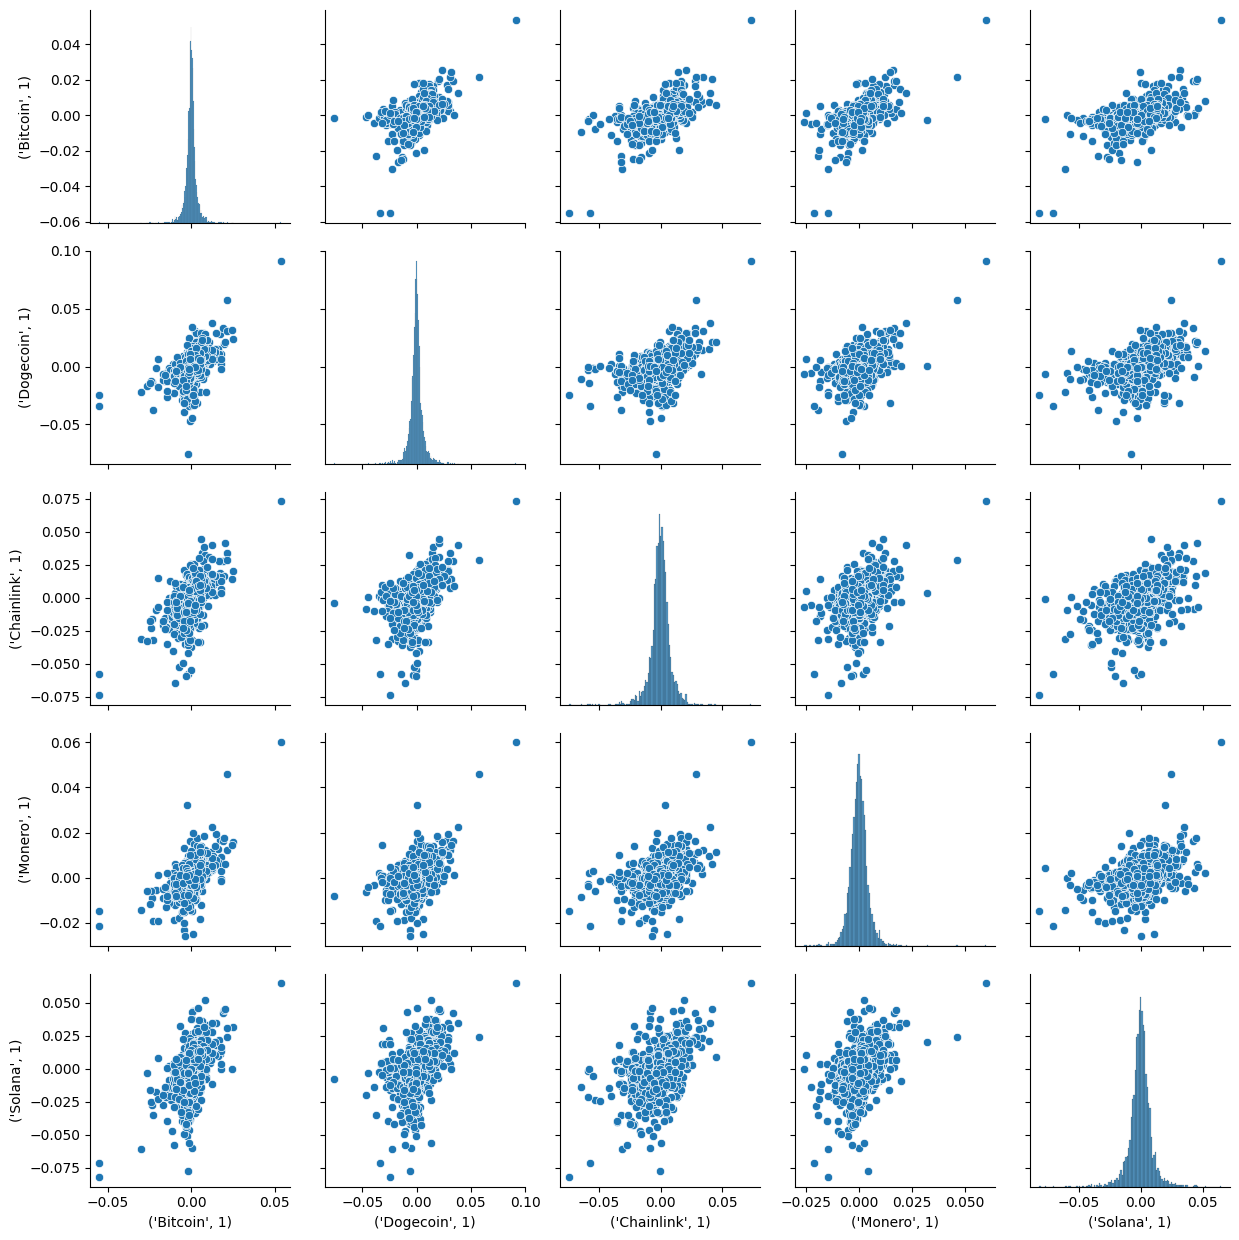

In [275]:
sns.pairplot(residuals)
plt.tight_layout()

In [246]:
# sns.pairplot(residuals_exog)

# plt.tight_layout()

In [247]:
# sns.pairplot(residuals_log)

# plt.tight_layout()

In [248]:
# residuals_log.corr()

In [249]:
# sns.pairplot(residuals_exog_log)

# plt.tight_layout()

### Time

In [250]:
# plot_residuals(residuals)

In [251]:
# plot_residuals(residuals_exog)

In [252]:
# plot_residuals(residuals_log)

In [253]:
# plot_residuals(residuals_exog_log)

## ML models

## Model validation

In [254]:
decision_tree = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "splitter": ["best"],
            "max_depth": [int(3), int(5), int(10), int(50)],
            "min_samples_split": [int(2), int(5),  int(50)],
            "min_samples_leaf": [int(1), int(2), int(10)],
            "max_features": ["sqrt"],
            "max_leaf_nodes": [int(10), int(20), int(50), int(100)],
        }
    }}

In [255]:
rf = {"Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [int(100), int(300)],
            "max_depth": [int(5), int(30)],
            "min_samples_split": [int(2), int(20)],
            "min_samples_leaf": [int(2), int(6)],
            "bootstrap": [False],  
            "oob_score": [False],
        }
    }}

In [256]:
rf_2 = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [int(100), int(200), int(300), int(500)],  # Aumentado o número de estimadores
            "max_depth": [int(5), int(10), int(20), int(30), int(40)],  # Aumentado o intervalo de profundidade máxima
            "min_samples_split": [int(2), int(5), int(10), int(15), int(20)],  # Mais valores para divisão mínima
            "min_samples_leaf": [int(1), int(2), int(4), int(6)],  # Adicionando mais valores de folhas mínimas
            "bootstrap": [True, False],  # Testando bootstrap
            "oob_score": [False],  # Mantido fixo, pois o bootstrap=False
            "max_features": ['sqrt', 'log2'],  # Adicionando max_features para mais variação
        }
    }
}


In [257]:
xgb = {"XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [int(100), int(500)],
            "max_depth": [int(3), int(15)],
            "learning_rate": [0.001, 0.01, 0.1],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7,  1.0],
            "gamma": [0.1, 0.3],
            "reg_alpha": [0.1, 1],
            "reg_lambda": [0.1,  1],
            "min_child_weight": [int(1), int(5)]
        }
}}

## 1 lag models

In [258]:
# one_lag_results_tree = optimize_and_evaluate_one_lag(criptos_diff, decision_tree)

In [259]:
# one_lag_results_tree.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_tree_ml.xlsx")

In [260]:
# one_lag_results_rf = optimize_and_evaluate_one_lag(criptos_diff, rf)

In [261]:
# one_lag_results_rf.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_rf_ml.xlsx")

In [262]:
# one_lag_results_xgb = optimize_and_evaluate_one_lag(criptos_diff, xgb)

In [263]:
# one_lag_results_xgb.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_xgb_ml.xlsx")

## Adding exogenous variables

In [264]:
y = criptos_diff['Bitcoin']
X = criptos_diff.drop('Bitcoin', axis=1)

In [265]:
y_diff = y.shift(1)

y_diff.dropna(inplace=True)

In [266]:
y_diff = pd.DataFrame(y_diff)

In [267]:
X = pd.merge(X, y_diff, left_index=True, right_index=True)

In [268]:
y = y.iloc[1:]

#### Decision tree

In [269]:
ml_results_tree = optimize_and_evaluate(X, y, decision_tree, train_size=0.8)

Otimizando Decision Tree...
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Total training time: 0.16 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Total training time: 0.08 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 50, 'splitter': 'best'}
Total training time: 0.06 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Total training time: 0.05 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Total training time: 0.05 seconds
Testando a combinação {'max_depth': 3, 'm

ValueError: Found input variables with inconsistent numbers of samples: [2783, 3723]

#### Random forest

In [ ]:
ml_results_rf = optimize_and_evaluate(X, y, rf)

In [ ]:
ml_results_rf_2 = optimize_and_evaluate(X, y, rf_2)

#### Xgboost

In [ ]:
ml_results_xgb = optimize_and_evaluate(X, y, xgb)

#### Saving to excel

In [ ]:
ml_results_tree.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_tree_ml_exog.xlsx")

In [ ]:
ml_results_rf.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_rf_ml_exog.xlsx")

In [ ]:
ml_results_xgb.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_xgb_ml_exog.xlsx")